In [1]:

import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from fredapi import Fred
from dataset import Dataset
import gtab
#sci-kit imports
from sklearn.linear_model import LinearRegression, Ridge
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
from sklearn.svm import LinearSVR
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline
from pipeline import Pipeline
from visualizations import Visualizer
np.random.seed(42)

In [2]:
#controling whether tensorflow does recognize my GPU
tf.config.get_visible_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = Dataset.get_btc_data()

In [4]:
data = data.loc["2014-9-17":]

In [5]:
data

,"BTC / Addresses, active, count","BTC / NVT, adjusted, 90d MA","BTC / NVT, adjusted, free float, 90d MA","BTC / NVT, adjusted","BTC / NVT, adjusted, free float","BTC / Flow, in, to exchanges, USD","BTC / Flow, out, from exchanges, USD","BTC / Fees, transaction, mean, USD","BTC / Fees, transaction, median, USD","BTC / Fees, total, USD",...,Close_IGV,Close_QQQ,Google_crypto_search,Wiki_crypto_search,RGDP_US,RGDP_PC_US,CPI_US,M2_US,USD_EUR_rate,BTC-USD
2014-09-17,191063.0,82.176970,76.651156,103.567097,96.602951,1.065752e+07,9.743524e+06,0.069971,0.045634,5494.516757,...,85.737656,92.093697,0.028571,NaN,18406.941,57536.0,1.677134,11506.0,1.2958,457.334015
2014-09-18,190890.0,76.826435,71.646822,75.335079,70.256013,1.696480e+07,1.359548e+07,0.068289,0.042688,5214.342615,...,86.452225,92.787651,0.028571,NaN,18406.941,57536.0,1.677134,11506.0,1.2913,424.440002
2014-09-19,172255.0,70.675713,65.897688,53.588317,49.965484,1.770344e+07,1.694158e+07,0.060801,0.039389,4261.732292,...,86.021515,92.730133,0.028571,NaN,18406.941,57536.0,1.677134,11506.0,1.2835,394.795990
2014-09-20,169941.0,73.687502,68.691994,74.395015,69.351542,9.387692e+06,8.728492e+06,0.066003,0.041104,4235.264753,...,NaN,NaN,0.028571,NaN,18406.941,57536.0,1.677134,11506.0,1.2835,408.903992
2014-09-21,200712.0,72.300627,67.387059,97.596787,90.964085,1.050540e+07,1.089809e+07,0.063093,0.040040,3638.427361,...,NaN,NaN,0.028571,NaN,18406.941,57536.0,1.677134,11506.0,1.2835,398.821014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,787672.0,71.420128,52.225802,190.545333,139.335829,1.683094e+08,1.959590e+08,1.348707,0.530874,306349.750545,...,NaN,NaN,26.035326,3483.0,21989.981,65799.0,6.516674,21428.3,NaN,16919.804688
2022-12-27,867369.0,71.311728,52.133758,146.054319,106.775712,2.861220e+08,2.541181e+08,1.629313,0.663281,393800.336021,...,251.721115,261.771362,26.035326,3747.0,21989.981,65799.0,6.516674,21428.3,1.0654,16717.173828
2022-12-28,904203.0,71.677896,52.380487,111.280678,81.321250,2.809234e+08,3.321595e+08,1.261058,0.607543,340456.769181,...,248.961319,258.315247,26.035326,4060.0,21989.981,65799.0,6.516674,21428.3,1.0622,16552.572266
2022-12-29,945186.0,73.206816,53.482266,106.721323,77.966758,2.713737e+08,3.133503e+08,1.263260,0.550805,337268.899500,...,256.320770,264.611725,26.035326,4064.0,21989.981,65799.0,6.516674,21428.3,1.0668,16642.341797


In [6]:
{col: [data[col].isnull().sum(), f'% {np.round(np.mean(data[col].isnull()*100), 3)}'
      ] for col in data.columns if data[col].isnull().any()}

{'BTC / Capitalization, market, estimated supply, USD': [1739, '% 57.45'],
 'Wiki_btc_search': [287, '% 9.481'],
 'Close_^DJI': [939, '% 31.021'],
 'Close_^GSPC': [939, '% 31.021'],
 'Close_GC=F': [942, '% 31.12'],
 'Close_^VIX': [939, '% 31.021'],
 'Close_^IXIC': [939, '% 31.021'],
 'Close_SMH': [939, '% 31.021'],
 'Close_VGT': [939, '% 31.021'],
 'Close_XSD': [939, '% 31.021'],
 'Close_IYW': [939, '% 31.021'],
 'Close_FTEC': [939, '% 31.021'],
 'Close_IGV': [939, '% 31.021'],
 'Close_QQQ': [939, '% 31.021'],
 'Wiki_crypto_search': [287, '% 9.481'],
 'USD_EUR_rate': [122, '% 4.03']}

In [7]:

data['Wiki_crypto_search'] = data['Wiki_crypto_search'].fillna(0)
data['Wiki_btc_search'] = data['Wiki_btc_search'].fillna(0)
#to be changed
data["BTC / Capitalization, market, estimated supply, USD"] = data["BTC / Capitalization, market, estimated supply, USD"].fillna(0)

In [8]:
data

,"BTC / Addresses, active, count","BTC / NVT, adjusted, 90d MA","BTC / NVT, adjusted, free float, 90d MA","BTC / NVT, adjusted","BTC / NVT, adjusted, free float","BTC / Flow, in, to exchanges, USD","BTC / Flow, out, from exchanges, USD","BTC / Fees, transaction, mean, USD","BTC / Fees, transaction, median, USD","BTC / Fees, total, USD",...,Close_IGV,Close_QQQ,Google_crypto_search,Wiki_crypto_search,RGDP_US,RGDP_PC_US,CPI_US,M2_US,USD_EUR_rate,BTC-USD
2014-09-17,191063.0,82.176970,76.651156,103.567097,96.602951,1.065752e+07,9.743524e+06,0.069971,0.045634,5494.516757,...,85.737656,92.093697,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2958,457.334015
2014-09-18,190890.0,76.826435,71.646822,75.335079,70.256013,1.696480e+07,1.359548e+07,0.068289,0.042688,5214.342615,...,86.452225,92.787651,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2913,424.440002
2014-09-19,172255.0,70.675713,65.897688,53.588317,49.965484,1.770344e+07,1.694158e+07,0.060801,0.039389,4261.732292,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,394.795990
2014-09-20,169941.0,73.687502,68.691994,74.395015,69.351542,9.387692e+06,8.728492e+06,0.066003,0.041104,4235.264753,...,NaN,NaN,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,408.903992
2014-09-21,200712.0,72.300627,67.387059,97.596787,90.964085,1.050540e+07,1.089809e+07,0.063093,0.040040,3638.427361,...,NaN,NaN,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,398.821014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,787672.0,71.420128,52.225802,190.545333,139.335829,1.683094e+08,1.959590e+08,1.348707,0.530874,306349.750545,...,NaN,NaN,26.035326,3483.0,21989.981,65799.0,6.516674,21428.3,NaN,16919.804688
2022-12-27,867369.0,71.311728,52.133758,146.054319,106.775712,2.861220e+08,2.541181e+08,1.629313,0.663281,393800.336021,...,251.721115,261.771362,26.035326,3747.0,21989.981,65799.0,6.516674,21428.3,1.0654,16717.173828
2022-12-28,904203.0,71.677896,52.380487,111.280678,81.321250,2.809234e+08,3.321595e+08,1.261058,0.607543,340456.769181,...,248.961319,258.315247,26.035326,4060.0,21989.981,65799.0,6.516674,21428.3,1.0622,16552.572266
2022-12-29,945186.0,73.206816,53.482266,106.721323,77.966758,2.713737e+08,3.133503e+08,1.263260,0.550805,337268.899500,...,256.320770,264.611725,26.035326,4064.0,21989.981,65799.0,6.516674,21428.3,1.0668,16642.341797


In [9]:
data[['Close_^DJI','Close_^GSPC','Close_GC=F','Close_^VIX','Close_^IXIC',
    'Close_SMH','Close_VGT','Close_XSD','Close_IYW','Close_FTEC','Close_IGV',
    'Close_QQQ','USD_EUR_rate']] = data[['Close_^DJI','Close_^GSPC','Close_GC=F','Close_^VIX','Close_^IXIC',
    'Close_SMH','Close_VGT','Close_XSD','Close_IYW','Close_FTEC','Close_IGV',
    'Close_QQQ','USD_EUR_rate']].ffill()
data["BTC-USD"] = data["BTC-USD"].shift(-10)
data = data.dropna()

In [10]:
data.head(20)

,"BTC / Addresses, active, count","BTC / NVT, adjusted, 90d MA","BTC / NVT, adjusted, free float, 90d MA","BTC / NVT, adjusted","BTC / NVT, adjusted, free float","BTC / Flow, in, to exchanges, USD","BTC / Flow, out, from exchanges, USD","BTC / Fees, transaction, mean, USD","BTC / Fees, transaction, median, USD","BTC / Fees, total, USD",...,Close_IGV,Close_QQQ,Google_crypto_search,Wiki_crypto_search,RGDP_US,RGDP_PC_US,CPI_US,M2_US,USD_EUR_rate,BTC-USD
2014-09-17,191063.0,82.176970,76.651156,103.567097,96.602951,1.065752e+07,9.743524e+06,0.069971,0.045634,5494.516757,...,85.737656,92.093697,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2958,399.519989
2014-09-18,190890.0,76.826435,71.646822,75.335079,70.256013,1.696480e+07,1.359548e+07,0.068289,0.042688,5214.342615,...,86.452225,92.787651,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2913,377.181000
2014-09-19,172255.0,70.675713,65.897688,53.588317,49.965484,1.770344e+07,1.694158e+07,0.060801,0.039389,4261.732292,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,375.467010
2014-09-20,169941.0,73.687502,68.691994,74.395015,69.351542,9.387692e+06,8.728492e+06,0.066003,0.041104,4235.264753,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,386.944000
2014-09-21,200712.0,72.300627,67.387059,97.596787,90.964085,1.050540e+07,1.089809e+07,0.063093,0.040040,3638.427361,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,383.614990
2014-09-22,206729.0,73.261390,68.284099,100.916807,94.060640,8.886442e+06,8.790132e+06,0.064278,0.040088,4737.862105,...,85.150337,91.867615,0.028571,0.0,18406.941,57536.0,1.677134,11427.3,1.2829,375.071991
2014-09-23,195635.0,80.369914,74.903667,83.346702,77.677993,1.760190e+07,1.289685e+07,0.072368,0.043849,5566.760392,...,84.553253,91.617165,0.028571,0.0,18406.941,57536.0,1.677134,11427.3,1.2858,359.511993
2014-09-24,189719.0,78.074315,72.748452,82.672581,77.033046,1.163822e+07,1.494228e+07,0.070217,0.042370,5287.516231,...,85.463104,92.600311,0.028571,0.0,18406.941,57536.0,1.677134,11427.3,1.2788,328.865997
2014-09-25,201394.0,75.681114,70.503972,88.420008,82.371431,9.461290e+06,1.084803e+07,0.068739,0.040954,5409.480099,...,83.778526,90.652573,0.028571,0.0,18406.941,57536.0,1.677134,11427.3,1.2748,320.510010
2014-09-26,180341.0,74.905453,69.765786,88.678665,82.593945,1.213704e+07,9.397632e+06,0.267096,0.040530,19395.689667,...,84.385780,91.617165,0.028571,0.0,18406.941,57536.0,1.677134,11427.3,1.2686,330.079010


In [32]:
from scikeras.wrappers import KerasRegressor
pipe = KerasRegressor(build_fn = Pipeline.assembly_lstm,
            verbose=1, random_state = 42, shuffle = True, batch_size = 1,epochs=50, input_shape=(1, 52),
                    units = 150)
tb_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)
x,y = Pipeline.create_lstm_input(data.copy(), data.copy().iloc[:,-1], 1)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
scaler = sklearn.preprocessing.RobustScaler(unit_variance=True)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
train_data = scaler.fit_transform(train_data.reshape((-1,52))).reshape(-1,1,52)
test_data = scaler.transform(test_data.reshape((-1,52))).reshape(-1,1,52)
model = pipe.fit(train_data, train_target,callbacks = [tb_callback])

Epoch 1/50
2713/2713 [==============================] - 16s 5ms/step - loss: 0.0231 - root_mean_squared_percentage_error: 0.0730 - root_mean_squared_error: 0.0730
Epoch 2/50
1547/2713 [================>.............] - ETA: 7s - loss: 0.0189 - root_mean_squared_percentage_error: 0.0685 - root_mean_squared_error: 0.0685

KeyboardInterrupt: 

In [12]:
mean_squared_percentage_error(train_target, pipe.predict(train_data),square_root=True)

2713/2713 [==============================] - 4s 1ms/step


2.120160196124484

   1/2713 [..............................] - ETA: 42s

302/302 [==============================] - 0s 1ms/step


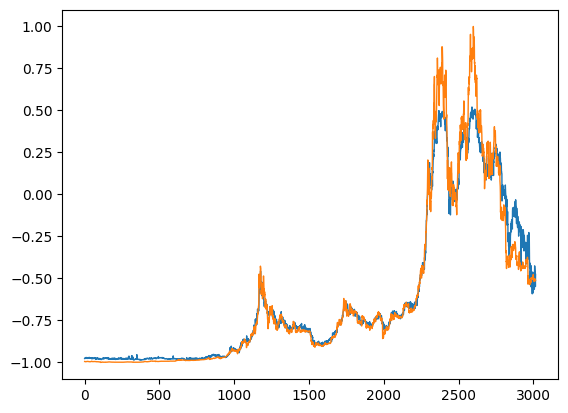

In [13]:
plt.plot(np.concatenate([pipe.predict(train_data),pipe.predict(test_data)]),linewidth=1)
plt.plot(np.concatenate([train_target,test_target]),linewidth=1)

In [14]:
data.columns

Index(['BTC / Addresses, active, count', 'BTC / NVT, adjusted, 90d MA',
       'BTC / NVT, adjusted, free float,  90d MA', 'BTC / NVT, adjusted',
       'BTC / NVT, adjusted, free float', 'BTC / Flow, in, to exchanges, USD',
       'BTC / Flow, out, from exchanges, USD',
       'BTC / Fees, transaction, mean, USD',
       'BTC / Fees, transaction, median, USD', 'BTC / Fees, total, USD',
       'BTC / Miner revenue, USD',
       'BTC / Capitalization, market, free float, USD',
       'BTC / Capitalization, realized, USD',
       'BTC / Capitalization, market, current supply, USD',
       'BTC / Capitalization, market, estimated supply, USD',
       'BTC / Volatility, daily returns, 30d',
       'BTC / Volatility, daily returns, 180d', 'BTC / Difficulty, last',
       'BTC / Difficulty, mean', 'BTC / Hash rate, mean',
       'BTC / Hash rate, mean, 30d', 'BTC / Revenue, per hash unit, USD',
       'BTC / Supply, Miner, held by all mining entities, USD',
       'BTC / Block, size, mean, b

In [15]:
data

,"BTC / Addresses, active, count","BTC / NVT, adjusted, 90d MA","BTC / NVT, adjusted, free float, 90d MA","BTC / NVT, adjusted","BTC / NVT, adjusted, free float","BTC / Flow, in, to exchanges, USD","BTC / Flow, out, from exchanges, USD","BTC / Fees, transaction, mean, USD","BTC / Fees, transaction, median, USD","BTC / Fees, total, USD",...,Close_IGV,Close_QQQ,Google_crypto_search,Wiki_crypto_search,RGDP_US,RGDP_PC_US,CPI_US,M2_US,USD_EUR_rate,BTC-USD
2014-09-17,191063.0,82.176970,76.651156,103.567097,96.602951,1.065752e+07,9.743524e+06,0.069971,0.045634,5494.516757,...,85.737656,92.093697,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2958,399.519989
2014-09-18,190890.0,76.826435,71.646822,75.335079,70.256013,1.696480e+07,1.359548e+07,0.068289,0.042688,5214.342615,...,86.452225,92.787651,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2913,377.181000
2014-09-19,172255.0,70.675713,65.897688,53.588317,49.965484,1.770344e+07,1.694158e+07,0.060801,0.039389,4261.732292,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,375.467010
2014-09-20,169941.0,73.687502,68.691994,74.395015,69.351542,9.387692e+06,8.728492e+06,0.066003,0.041104,4235.264753,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,386.944000
2014-09-21,200712.0,72.300627,67.387059,97.596787,90.964085,1.050540e+07,1.089809e+07,0.063093,0.040040,3638.427361,...,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835,383.614990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16,893040.0,63.638479,46.708248,92.241011,67.701429,3.249423e+08,5.647839e+08,1.104805,0.457664,285957.077723,...,257.900665,271.717651,26.035326,4349.0,21989.981,65799.0,6.516674,21438.7,1.0610,16919.804688
2022-12-17,967830.0,64.715648,47.484694,152.352954,111.788007,2.299792e+08,3.900930e+08,1.077419,0.459618,281394.393781,...,257.900665,271.717651,26.035326,4093.0,21989.981,65799.0,6.516674,21438.7,1.0610,16717.173828
2022-12-18,783263.0,65.484320,48.038009,200.559814,147.126736,1.658453e+08,1.982145e+08,0.905575,0.376875,188281.093604,...,257.900665,271.717651,26.035326,4594.0,21989.981,65799.0,6.516674,21438.7,1.0610,16552.572266
2022-12-19,971140.0,65.030832,47.686621,100.344436,73.581821,3.266879e+08,3.518762e+08,1.154616,0.445258,302527.709863,...,254.090927,267.899017,26.035326,4774.0,21989.981,65799.0,6.516674,21453.1,1.0624,16642.341797


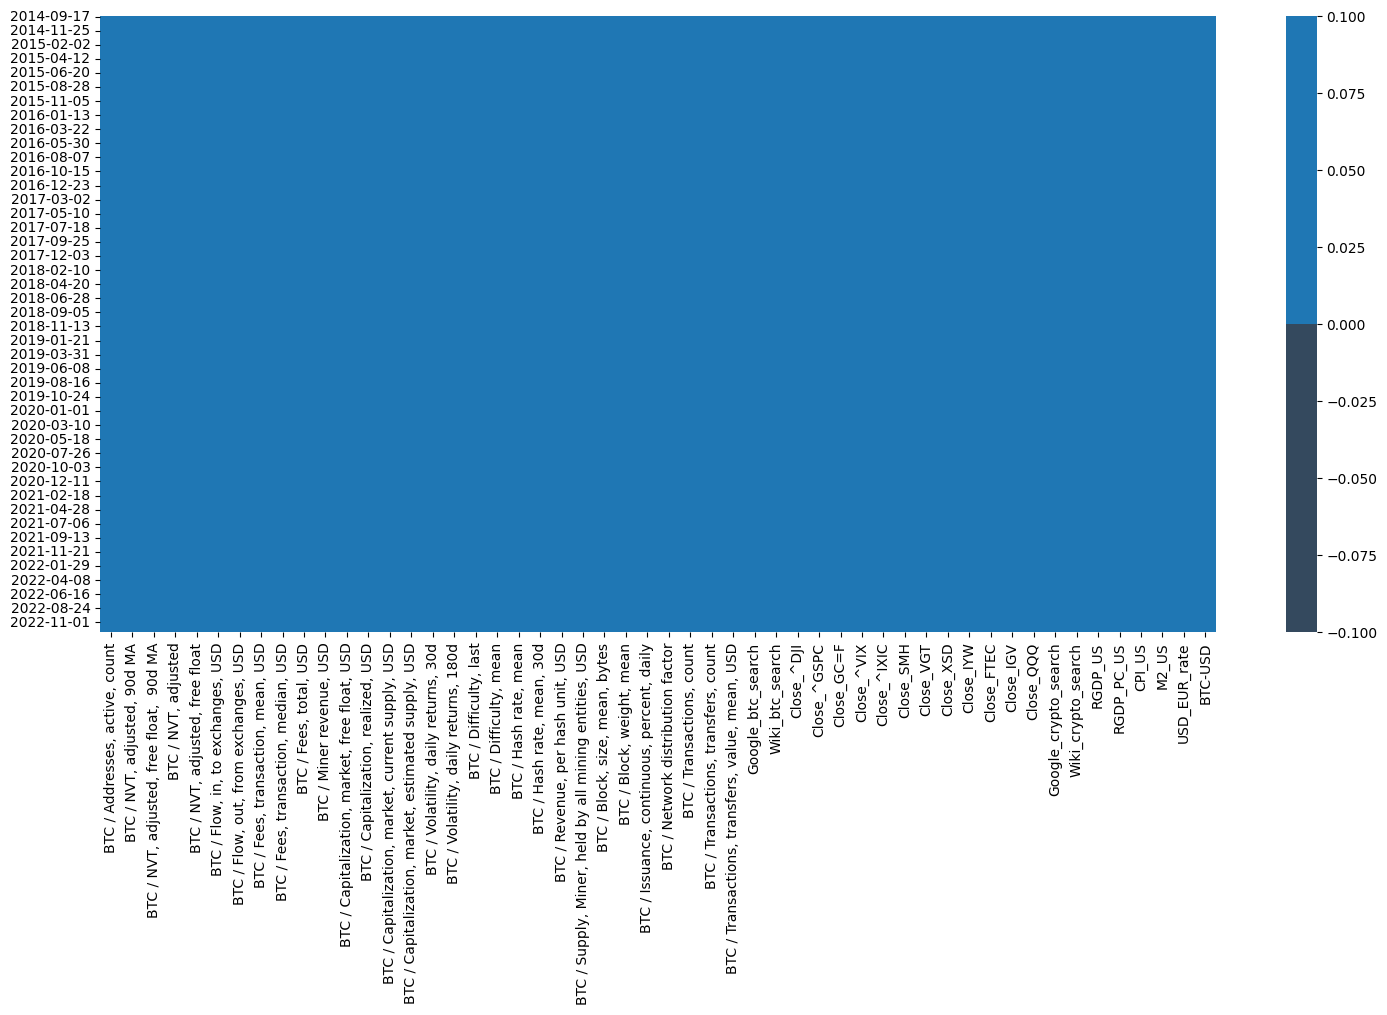

In [16]:
fig = Visualizer.draw_missing_data(data)
fig.show()

In [17]:
""" data.drop(["BTC / Capitalization, market, free float, USD",
           "BTC / Capitalization, realized, USD",
           "BTC / Capitalization, market, current supply, USD",
           "BTC / Capitalization, market, estimated supply, USD"], axis = 1, inplace=True) """

' data.drop(["BTC / Capitalization, market, free float, USD",\n           "BTC / Capitalization, realized, USD",\n           "BTC / Capitalization, market, current supply, USD",\n           "BTC / Capitalization, market, estimated supply, USD"], axis = 1, inplace=True) '

In [18]:
train_data, validation_data, train_target, validation_target = sklearn.model_selection.train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size = 0.1, random_state=42, shuffle=False)
scaler = sklearn.preprocessing.RobustScaler()
pipe = sklearn.pipeline.Pipeline([("scaler",scaler),("estimator",LinearSVR())])
from pipeline import Pipeline
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(), dim_reducer = None)
parameter_grid = {"scaler__unit_variance":[True,False],"estimator__C": [0.2,0.5,0.7,1,3,5,10,20,30]}
split = sklearn.model_selection.TimeSeriesSplit(n_splits=3)
model = sklearn.model_selection.GridSearchCV(pipe, parameter_grid,cv=split, scoring = 'neg_root_mean_squared_error', verbose = 4, n_jobs=-1).fit(train_data,train_target)
print(model.best_params_)
print(model.best_estimator_)
print(model.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change f

[CV 2/3] END estimator__C=0.2, scaler__unit_variance=False;, score=-4032.355 total time=   0.1s[CV 2/3] END estimator__C=0.5, scaler__unit_variance=False;, score=-4457.124 total time=   0.2s

[CV 1/3] END estimator__C=0.2, scaler__unit_variance=True;, score=-7660.880 total time=   0.1s
[CV 1/3] END estimator__C=0.5, scaler__unit_variance=True;, score=-4664.738 total time=   0.2s
[CV 1/3] END estimator__C=0.2, scaler__unit_variance=False;, score=-8715.889 total time=   0.2s
[CV 1/3] END estimator__C=0.5, scaler__unit_variance=False;, score=-5260.170 total time=   0.2s
[CV 2/3] END estimator__C=0.5, scaler__unit_variance=True;, score=-4352.714 total time=   0.4s
[CV 1/3] END estimator__C=0.7, scaler__unit_variance=False;, score=-3837.641 total time=   0.2s
[CV 1/3] END estimator__C=1, scaler__unit_variance=True;, score=-3748.213 total time=   0.2s
[CV 1/3] END estimator__C=0.7, scaler__unit_variance=True;, score=-4101.406 total time=   0.2s
[CV 2/3] END estimator__C=0.7, scaler__unit_var

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default valu

[CV 2/3] END estimator__C=5, scaler__unit_variance=True;, score=-1950.206 total time=   0.1s
[CV 3/3] END estimator__C=0.7, scaler__unit_variance=False;, score=-27197.044 total time=   0.7s
[CV 1/3] END estimator__C=10, scaler__unit_variance=True;, score=-3969.833 total time=   0.0s
[CV 2/3] END estimator__C=5, scaler__unit_variance=False;, score=-2195.955 total time=   0.0s
[CV 3/3] END estimator__C=0.2, scaler__unit_variance=True;, score=-32243.205 total time=   0.6s
[CV 1/3] END estimator__C=10, scaler__unit_variance=False;, score=-3373.143 total time=   0.0s
[CV 3/3] END estimator__C=1, scaler__unit_variance=True;, score=-21055.162 total time=   0.2s
[CV 2/3] END estimator__C=10, scaler__unit_variance=True;, score=-1639.895 total time=   0.1s
[CV 2/3] END estimator__C=10, scaler__unit_variance=False;, score=-1822.857 total time=   0.0s
[CV 3/3] END estimator__C=1, scaler__unit_variance=False;, score=-24098.085 total time=   0.2s
[CV 3/3] END estimator__C=3, scaler__unit_variance=Tr

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [19]:
model

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('pack_down', None),
                                       ('scaler',
                                        RobustScaler(unit_variance=True)),
                                       ('denoiser', None), ('scaler 2', None),
                                       ('pack_up,', None),
                                       ('estimator', LinearSVR())]),
             n_jobs=-1,
             param_grid={'estimator__C': [0.2, 0.5, 0.7, 1, 3, 5, 10, 20, 30],
                         'scaler__unit_variance': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=4)

In [20]:
[(el[0].shape, el[1].shape) for el in split.split(train_data)]

[((681,), (678,)), ((1359,), (678,)), ((2037,), (678,))]

In [21]:
validation_data

,"BTC / Addresses, active, count","BTC / NVT, adjusted, 90d MA","BTC / NVT, adjusted, free float, 90d MA","BTC / NVT, adjusted","BTC / NVT, adjusted, free float","BTC / Flow, in, to exchanges, USD","BTC / Flow, out, from exchanges, USD","BTC / Fees, transaction, mean, USD","BTC / Fees, transaction, median, USD","BTC / Fees, total, USD",...,Close_FTEC,Close_IGV,Close_QQQ,Google_crypto_search,Wiki_crypto_search,RGDP_US,RGDP_PC_US,CPI_US,M2_US,USD_EUR_rate
2022-02-22,886571.0,47.491680,36.654012,47.480215,36.645163,6.934864e+08,6.611248e+08,1.298124,0.323194,332638.066137,...,114.544205,324.820435,333.303772,74.651562,8958.0,21738.871,65284.0,7.831419,21566.8,1.1342
2022-02-23,859810.0,47.346817,36.545605,83.326693,64.317405,4.991372e+08,5.911137e+08,1.203565,0.272350,305175.896505,...,111.575920,316.721649,324.766174,74.651562,8257.0,21738.871,65284.0,7.831419,21566.8,1.1316
2022-02-24,958866.0,48.942864,37.762073,36.182918,27.917084,1.521154e+09,1.346757e+09,1.559682,0.397386,398929.537073,...,115.704002,336.018738,335.679749,74.651562,8845.0,21738.871,65284.0,7.831419,21566.8,1.1154
2022-02-25,936543.0,50.077995,38.644633,47.218269,36.437815,8.941904e+08,8.168845e+08,1.720415,0.385373,449039.427813,...,117.325737,338.638306,340.885132,74.651562,7269.0,21738.871,65284.0,7.831419,21566.8,1.1261
2022-02-26,818914.0,49.905015,38.511097,127.711596,98.553496,4.388788e+08,3.891544e+08,1.186148,0.288238,263340.238548,...,117.325737,338.638306,340.885132,74.651562,6676.0,21738.871,65284.0,7.831419,21566.8,1.1261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16,893040.0,63.638479,46.708248,92.241011,67.701429,3.249423e+08,5.647839e+08,1.104805,0.457664,285957.077723,...,95.663918,257.900665,271.717651,26.035326,4349.0,21989.981,65799.0,6.516674,21438.7,1.0610
2022-12-17,967830.0,64.715648,47.484694,152.352954,111.788007,2.299792e+08,3.900930e+08,1.077419,0.459618,281394.393781,...,95.663918,257.900665,271.717651,26.035326,4093.0,21989.981,65799.0,6.516674,21438.7,1.0610
2022-12-18,783263.0,65.484320,48.038009,200.559814,147.126736,1.658453e+08,1.982145e+08,0.905575,0.376875,188281.093604,...,95.663918,257.900665,271.717651,26.035326,4594.0,21989.981,65799.0,6.516674,21438.7,1.0610
2022-12-19,971140.0,65.030832,47.686621,100.344436,73.581821,3.266879e+08,3.518762e+08,1.154616,0.445258,302527.709863,...,94.265976,254.090927,267.899017,26.035326,4774.0,21989.981,65799.0,6.516674,21453.1,1.0624


In [22]:
predictions = model.predict(validation_data)

In [23]:
train_data

,"BTC / Addresses, active, count","BTC / NVT, adjusted, 90d MA","BTC / NVT, adjusted, free float, 90d MA","BTC / NVT, adjusted","BTC / NVT, adjusted, free float","BTC / Flow, in, to exchanges, USD","BTC / Flow, out, from exchanges, USD","BTC / Fees, transaction, mean, USD","BTC / Fees, transaction, median, USD","BTC / Fees, total, USD",...,Close_FTEC,Close_IGV,Close_QQQ,Google_crypto_search,Wiki_crypto_search,RGDP_US,RGDP_PC_US,CPI_US,M2_US,USD_EUR_rate
2014-09-17,191063.0,82.176970,76.651156,103.567097,96.602951,1.065752e+07,9.743524e+06,0.069971,0.045634,5494.516757,...,27.694853,85.737656,92.093697,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2958
2014-09-18,190890.0,76.826435,71.646822,75.335079,70.256013,1.696480e+07,1.359548e+07,0.068289,0.042688,5214.342615,...,27.885284,86.452225,92.787651,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2913
2014-09-19,172255.0,70.675713,65.897688,53.588317,49.965484,1.770344e+07,1.694158e+07,0.060801,0.039389,4261.732292,...,27.767048,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835
2014-09-20,169941.0,73.687502,68.691994,74.395015,69.351542,9.387692e+06,8.728492e+06,0.066003,0.041104,4235.264753,...,27.767048,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835
2014-09-21,200712.0,72.300627,67.387059,97.596787,90.964085,1.050540e+07,1.089809e+07,0.063093,0.040040,3638.427361,...,27.767048,86.021515,92.730133,0.028571,0.0,18406.941,57536.0,1.677134,11506.0,1.2835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,931220.0,49.688082,38.345206,37.027576,28.574861,6.544876e+08,9.035806e+08,1.599223,0.413816,409751.837519,...,117.197975,334.708923,340.569672,74.651562,8488.0,21738.871,65284.0,7.831419,21562.5,1.1364
2022-02-18,940726.0,48.906244,37.741825,50.962697,39.328827,7.657248e+08,7.709275e+08,1.423172,0.344380,367724.748053,...,115.664688,327.540009,336.685425,74.651562,7236.0,21738.871,65284.0,7.831419,21562.5,1.1327
2022-02-19,839236.0,48.719759,37.597678,51.034376,39.383898,3.421791e+08,4.071114e+08,1.230944,0.297111,268355.717813,...,115.664688,327.540009,336.685425,74.651562,6847.0,21738.871,65284.0,7.831419,21562.5,1.1327
2022-02-20,741534.0,47.162432,36.396198,79.206384,61.125161,4.265360e+08,3.952858e+08,1.107203,0.246730,224396.524260,...,115.664688,327.540009,336.685425,74.651562,7563.0,21738.871,65284.0,7.831419,21562.5,1.1327


In [24]:
len(predictions)

302

In [25]:
validation_target.iloc[10:]

2022-03-04    39666.753906
2022-03-05    39338.785156
2022-03-06    41143.929688
2022-03-07    40951.378906
2022-03-08    41801.156250
                  ...     
2022-12-16    16919.804688
2022-12-17    16717.173828
2022-12-18    16552.572266
2022-12-19    16642.341797
2022-12-20    16602.585938
Name: BTC-USD, Length: 292, dtype: float64

In [26]:
validation_target.shift(10).dropna()

2022-03-04    39137.605469
2022-03-05    39400.585938
2022-03-06    38419.984375
2022-03-07    38062.039062
2022-03-08    38737.269531
                  ...     
2022-12-16    16647.484375
2022-12-17    16795.091797
2022-12-18    16757.976562
2022-12-19    16439.679688
2022-12-20    16906.304688
Name: BTC-USD, Length: 292, dtype: float64

In [27]:
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
mean_squared_percentage_error(validation_target.shift(10).dropna(),validation_target.iloc[10:])

0.009395713107008985

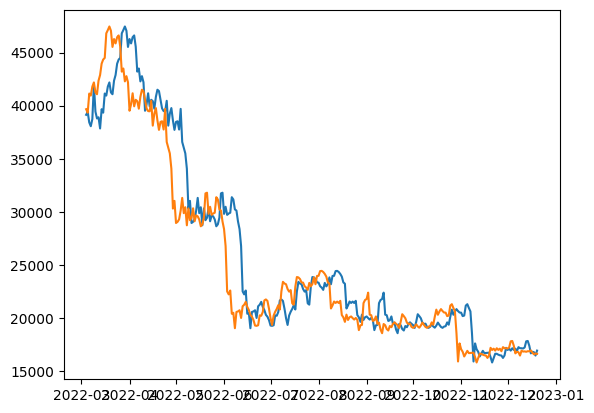

In [28]:
plt.plot(validation_target.shift(10).dropna())
plt.plot(validation_target.iloc[10:])

In [29]:
y_pred = pd.Series(predictions, index=validation_data.index)
train_pred = pd.Series(model.predict(train_data), index = train_data.index)

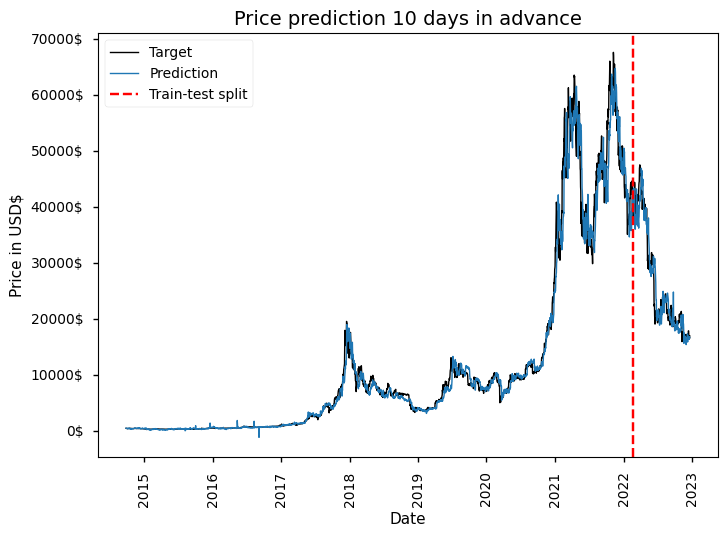

In [30]:
visualizer = Visualizer()
fig = visualizer.draw_prediction_full(train_target, train_pred, validation_target, y_pred, 10)
fig.show()

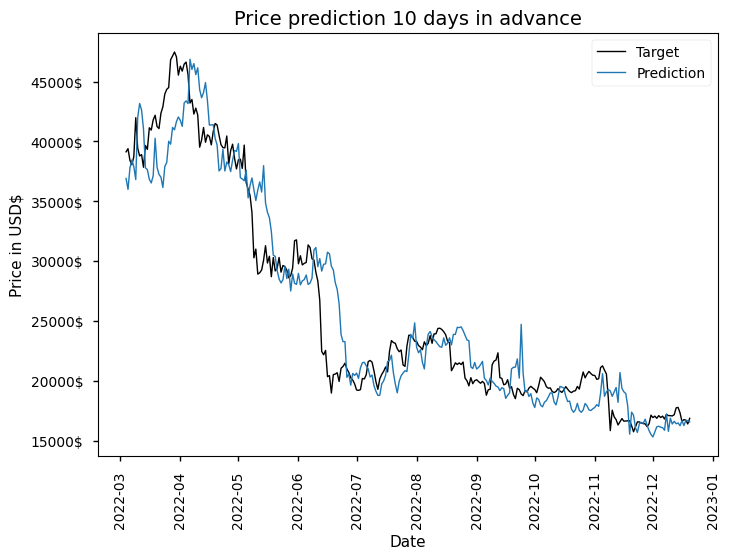

In [31]:
fig = visualizer.draw_prediction_test(validation_target, y_pred, 10)
fig.show()